# Import all Moduls

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image

cudnn.benchmark = True
plt.ion()

# Load Data

In [46]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(232),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(232),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])}

data_dir = 'Images1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),
                                            data_transforms[x])
                  for x in ['train','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images

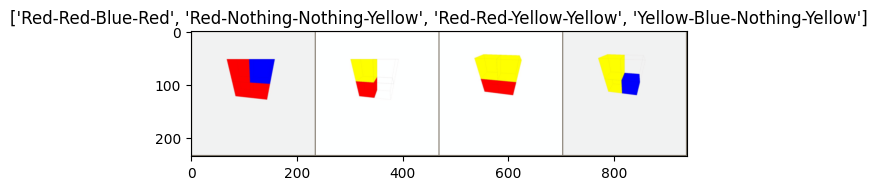

In [47]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Model Training

In [48]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    best_model_params_path = os.path.join('Model', 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

# Visualizing the model predicitions

In [49]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the ConvNet

In [50]:
model_ft = models.mobilenet_v2(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier[1].in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [51]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=13)

Epoch 0/12
----------
train Loss: 3.4695 Acc: 0.3020
test Loss: 1.3800 Acc: 0.6203

Training complete in 1m 2s
Best val Acc: 0.620316
Epoch 1/12
----------
train Loss: 0.6568 Acc: 0.9551
test Loss: 0.4126 Acc: 0.9073

Training complete in 2m 6s
Best val Acc: 0.907298
Epoch 2/12
----------
train Loss: 0.1579 Acc: 0.9995
test Loss: 0.2684 Acc: 0.9236

Training complete in 3m 9s
Best val Acc: 0.923570
Epoch 3/12
----------
train Loss: 0.0802 Acc: 1.0000
test Loss: 0.3017 Acc: 0.8984

Training complete in 4m 12s
Best val Acc: 0.923570
Epoch 4/12
----------
train Loss: 0.0840 Acc: 1.0000
test Loss: 0.3615 Acc: 0.8748

Training complete in 5m 14s
Best val Acc: 0.923570
Epoch 5/12
----------
train Loss: 0.0821 Acc: 0.9998
test Loss: 0.3128 Acc: 0.8994

Training complete in 6m 18s
Best val Acc: 0.923570
Epoch 6/12
----------
train Loss: 0.0804 Acc: 1.0000
test Loss: 0.3065 Acc: 0.9029

Training complete in 7m 23s
Best val Acc: 0.923570
Epoch 7/12
----------
train Loss: 0.0909 Acc: 1.0000
test 

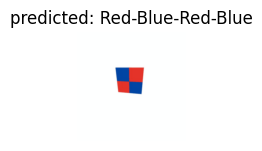

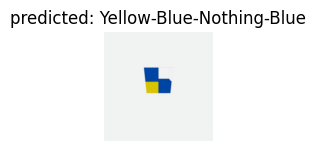

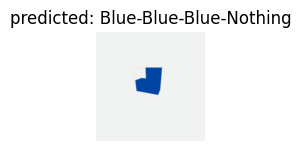

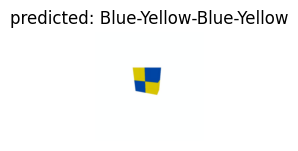

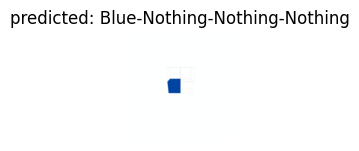

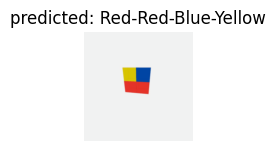

In [52]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor

In [53]:
model_conv = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V2')
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=13)

Epoch 0/12
----------
train Loss: 4.3227 Acc: 0.1935
test Loss: 1.9340 Acc: 0.4561

Training complete in 1m 1s
Best val Acc: 0.456114
Epoch 1/12
----------
train Loss: 0.7724 Acc: 0.8969
test Loss: 0.7661 Acc: 0.8210

Training complete in 2m 4s
Best val Acc: 0.821006
Epoch 2/12
----------
train Loss: 0.1405 Acc: 0.9990
test Loss: 0.7112 Acc: 0.8126

Training complete in 3m 6s
Best val Acc: 0.821006
Epoch 3/12
----------
train Loss: 0.1397 Acc: 0.9993
test Loss: 0.7348 Acc: 0.8151

Training complete in 4m 12s
Best val Acc: 0.821006
Epoch 4/12
----------
train Loss: 0.1411 Acc: 0.9988
test Loss: 0.7570 Acc: 0.8131

Training complete in 5m 17s
Best val Acc: 0.821006
Epoch 5/12
----------
train Loss: 0.1369 Acc: 0.9993
test Loss: 0.7638 Acc: 0.7860

Training complete in 6m 23s
Best val Acc: 0.821006
Epoch 6/12
----------
train Loss: 0.1369 Acc: 0.9995
test Loss: 0.7469 Acc: 0.8131

Training complete in 7m 41s
Best val Acc: 0.821006
Epoch 7/12
----------
train Loss: 0.1983 Acc: 0.9985
test 

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['test'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        print(class_names[preds[0]])

        model.train(mode=was_training)

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='Images/test/Screenshot_2024-04-04-09-30-05.png'
)


plt.ioff()
plt.show()

# Save the Model

In [ ]:
model_scripted = torch.jit.script(model_conv) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

# Load the Model

In [ ]:
model_load = torch.jit.load('model_scripted.pt')
model_load.eval()

# Bilderkennung

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['test'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        
        detected_label = class_names[preds[0]]
        cubes = detected_label.split("-")

        model.train(mode=was_training)
        return cubes

In [ ]:
visualize_model_predictions(
    model_load,
    img_path='Images/train/Blue-Blue-Blue-Nothing/Blue-Blue-Blue-Nothing12.jpg'
)

In [ ]:
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0